In [11]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.animation as animation
import numpy as np
import math
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import davies_bouldin_score

# Dados

In [2]:
quake=pd.read_csv('dados/quake.csv',header=None)
quake=quake.rename(columns={quake.columns[0]:'latitude',quake.columns[1]:'longitude'})
quake

,latitude,longitude
0,-52.26,28.30
1,45.53,150.93
2,41.85,142.78
3,29.19,141.15
4,-21.66,169.81
...,...,...
2173,51.54,-173.11
2174,-10.16,161.01
2175,27.87,139.51
2176,36.43,140.98


In [6]:
penguins=pd.read_csv('dados/penguins.csv',header=None)
penguins=penguins.rename(columns={penguins.columns[4]:'y'})
penguins

,0,1,2,3,y
0,39.1,18.7,181.0,3750.0,0.0
1,39.5,17.4,186.0,3800.0,0.0
2,40.3,18.0,195.0,3250.0,0.0
3,36.7,19.3,193.0,3450.0,0.0
4,39.3,20.6,190.0,3650.0,0.0
...,...,...,...,...,...
328,55.8,19.8,207.0,4000.0,1.0
329,43.5,18.1,202.0,3400.0,1.0
330,49.6,18.2,193.0,3775.0,1.0
331,50.8,19.0,210.0,4100.0,1.0


In [7]:
set(penguins.y)

{0.0, 1.0, 2.0}

# Normalizador

In [47]:
class Nomalizer:
    def __init__(self):
        self.y_max=0.0
        self.y_min=0.0
        self.x_max=[]
        self.x_min=[]

    def fit(self,x):
        # Pega os valores minimos de 
        #self.y_max=y['y'].max().tolist()
        #self.y_min=y['y'].min().tolist()

        # Pega os valores maximos e minimos do X
        self.x_max=x.max().tolist()
        self.x_min=x.min().tolist()
    
    def normalize(self,x):
        #y_norm=y.map(self.y_norm_aux)
        x_norm=x.copy()
        norm_index=0
        for column in x.columns:
            x_column=[]
            for i in range(len(x[column])):
                x_column.append((x[column][i]-self.x_min[norm_index])/(self.x_max[norm_index]-self.x_min[norm_index]))
                
            norm_index+=1
            x_norm[column]=x_column    
        
        return x_norm#,y_norm
    
    def desnormalize(self,x_norm):
        #y=y_norm.map(self.y_desnorm_aux)
        x=x_norm.copy()
        norm_index=0
        for column in x_norm.columns:
            x_column=[]
            for i in range(len(x_norm[column])):
                x_column.append((x_norm[column][i]*(self.x_max[norm_index]-self.x_min[norm_index]))+self.x_min[norm_index])
                
            norm_index+=1
            x[column]=x_column    
        
        return x#,y
    
    def y_norm_aux(self,y):
        return (y-self.y_min)/(self.y_max-self.y_min)
    
    def y_desnorm_aux(self,y):
        return (y*(self.y_max-self.y_min))+self.y_min

# K-means

## Modelo

In [27]:
class KMeans:
    def __init__(self, max_iterations=100, tol=1e-4, random_state=42):
        """
        Inicializa o algoritmo K-Means.
        
        Parâmetros:
            max_iterations: int, número máximo de iterações.
            tol: float, tolerância para convergência.
            random_state: int, semente para replicabilidade.
        """
        self.max_iterations = max_iterations
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.best_k = None
        self.data = None

    
    def euclidean_distance(self,point1, point2):
        """
        Calcula a distância euclidiana entre dois pontos.
        """
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _fit_single_k(self, data, k):
        """
        Ajusta o modelo com um número fixo de clusters (k).
        """
        np.random.seed(self.random_state)
        data_values = data.values

        # Inicializar centróides aleatoriamente
        indices = np.random.choice(data_values.shape[0], k, replace=False)
        centroids = data_values[indices]

        for iteration in range(self.max_iterations):
            # Etapa 1: Atribuir cada ponto ao cluster mais próximo
            labels = np.array([np.argmin([self.euclidean_distance(point, centroid) for centroid in centroids]) for point in data_values])
            
            # Etapa 2: Atualizar os centróides com a média dos pontos atribuídos
            new_centroids = np.array([data_values[labels == cluster].mean(axis=0) if len(data_values[labels == cluster]) > 0 else centroids[cluster]
                                       for cluster in range(k)])
            
            # Checar convergência
            if np.all(np.abs(new_centroids - centroids) < self.tol):
                break
            
            centroids = new_centroids

        return centroids, labels

    def fit(self, data, range_k):
        """
        Ajusta o modelo para o intervalo de k fornecido, escolhendo o melhor valor de k com base no índice DB.
        
        Parâmetros:
            data: pandas DataFrame, dados para clustering (m x n).
            range_k: tuple, intervalo de valores possíveis para k (exemplo: (2, 10)).
        """
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Os dados de entrada devem ser um DataFrame do pandas.")
        if not isinstance(range_k, tuple) or len(range_k) != 2:
            raise ValueError("O intervalo de k deve ser uma tupla com dois valores.")

        best_db_index = float('inf')  # Inicializar com um valor alto
        best_centroids = None
        best_labels = None
        

        for k in range(range_k[0], range_k[1] + 1):
            centroids, labels = self._fit_single_k(data, k)
            db_index = davies_bouldin_score(data.values, labels)

            if db_index < best_db_index:
                best_db_index = db_index
                self.best_k = k
                best_centroids = centroids
                best_labels = labels

        self.centroids = best_centroids
        self.labels = best_labels
        self.data=data

    def predict(self, data):
        """
        Prediz o cluster para novos dados.
        
        Parâmetros:
            data: pandas DataFrame, dados para predição (m x n).
        
        Retorna:
            labels: array com os rótulos dos clusters.
        """
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Os dados de entrada devem ser um DataFrame do pandas.")
        data_values = data.values

        return np.array([np.argmin([self.euclidean_distance(point, centroid) for centroid in self.centroids]) for point in data_values])
    
    def plot_clusters(self):
        """
        Plota os clusters com seus centróides.
        
        Parâmetros:
            data: pandas DataFrame, dados utilizados no clustering.
            centroids: array, coordenadas dos centróides.
            labels: array, rótulos dos clusters.
            best_k: int, melhor número de clusters.
        """
        # Cores para os clusters
        colors = ['red', 'blue', 'green', 'magenta', 'orange', 'purple', 'cyan', 'brown']
        
        if self.best_k > len(colors):
            raise ValueError("Número de clusters maior que as cores disponíveis. Aumente a paleta de cores.")
        
        # Criar figura e eixo
        fig, ax = plt.subplots()
        
        # Plotar cada cluster
        for i in range(self.best_k):
            cluster_points = self.data.values[self.labels == i]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f'Cluster {i + 1}')
        
        # Plotar os centróides
        ax.scatter(self.centroids[:, 0], self.centroids[:, 1], color='black', marker='o', s=200, label='Centróides', edgecolor='white')
        
        # Configurações do gráfico
        ax.set_title(f'DB Index - Melhor k = {self.best_k}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Legenda")
        
        # Ajustar layout para acomodar a legenda fora do gráfico
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()


## Experimento 

In [28]:
# Executar k-means com busca do melhor k no intervalo (2, 4)
kmeans = KMeans()
kmeans.fit(quake, range_k=(4, 20))

print("Melhor valor de k:")
print(kmeans.best_k)
print("Centróides finais:")
print(kmeans.centroids)
print("Rótulos dos pontos:")
print(kmeans.labels)

Melhor valor de k:
5
Centróides finais:
[[  35.07891697   54.39202166]
 [  41.24748649  146.82597297]
 [  -4.60290172 -116.08798752]
 [ -13.6824186   159.55093023]
 [   2.60152174  121.77784783]]
Rótulos dos pontos:
[0 1 1 ... 1 1 4]


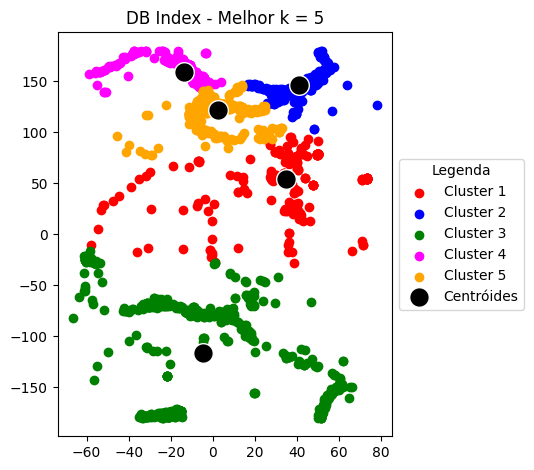

In [29]:
kmeans.plot_clusters()

# PCA

## Modelo

In [39]:
class PCA:
    def __init__(self, n_components):
        """
        Inicializa o modelo PCA.
        
        Parâmetros:
        n_components (int): Número de componentes principais desejados.
        """
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None

    def fit(self, X):
        """
        Ajusta o modelo PCA aos dados.
        
        Parâmetros:
        X (pandas DataFrame): Dados de entrada (n_samples x n_features).
        """
        # Converter para numpy array se for DataFrame
        X = X.values if isinstance(X, pd.DataFrame) else X
        
        # Centralizar os dados (subtrair a média)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Calcular a matriz de covariância
        covariance_matrix = np.cov(X_centered, rowvar=False)
        
        # Obter os autovalores e autovetores
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        
        # Ordenar os autovalores em ordem decrescente
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        # Calcular a variância explicada
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues / total_variance
        
        # Selecionar os autovetores correspondentes aos n_components maiores
        self.components = eigenvectors[:, :self.n_components]

    def transform(self, X):
        """
        Transforma os dados usando os componentes principais ajustados.
        
        Parâmetros:
        X (pandas DataFrame): Dados de entrada (n_samples x n_features).
        
        Retorna:
        np.array: Dados transformados (n_samples x n_components).
        """
        # Converter para numpy array se for DataFrame
        X = X.values if isinstance(X, pd.DataFrame) else X
        
        # Centralizar os dados
        X_centered = X - self.mean
        
        # Projetar os dados nos componentes principais
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        """
        Ajusta o modelo PCA e transforma os dados.
        
        Parâmetros:
        X (pandas DataFrame): Dados de entrada (n_samples x n_features).
        
        Retorna:
        np.array: Dados transformados (n_samples x n_components).
        """
        self.fit(X)
        return self.transform(X)

    def explained_variance(self):
        """
        Retorna a variância explicada acumulada para os n_components.
        
        Retorna:
        list: Variação explicada por cada componente.
        """
        return np.cumsum(self.explained_variance_ratio[:self.n_components])

## Experimento

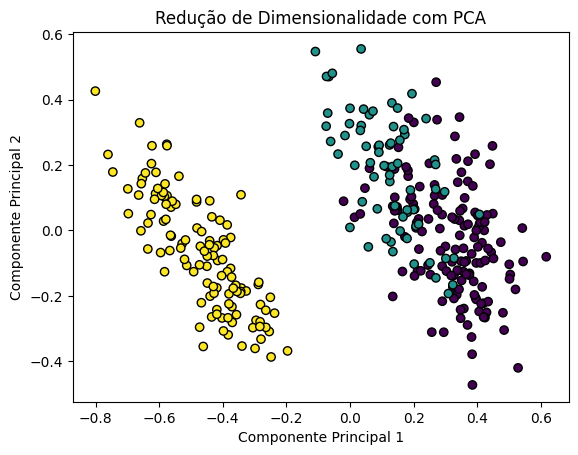

In [52]:
# Normalização dos dados
norm=Nomalizer()
penguin_x=penguins[[0,1,2,3]]
norm.fit(penguin_x)
penguin_norm_x=norm.normalize(penguin_x)

# Criar e ajustar o modelo PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(penguin_norm_x)

# Mostrar os dados reduzidos
#print("Dados reduzidos (2 componentes principais):")
#print(X_reduced)

# Visualizar os dados reduzidos (opcional)
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=penguins.y, cmap='viridis', edgecolor='k')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Redução de Dimensionalidade com PCA')
plt.show()

In [51]:
for n in range(1, 5):  # Dimensões 1 a 4
    norm=Nomalizer()
    penguin_x=penguins[[0,1,2,3]]
    norm.fit(penguin_x)
    penguin_norm_x=norm.normalize(penguin_x)
    pca = PCA(n_components=n)
    pca.fit(penguins[[0,1,2,3]])
    explained_variance = pca.explained_variance()
    print(f"Variação explicada com {n} componentes principais: {explained_variance[-1]:.2%}")

Variação explicada com 1 componentes principais: 99.99%
Variação explicada com 2 componentes principais: 100.00%
Variação explicada com 3 componentes principais: 100.00%
Variação explicada com 4 componentes principais: 100.00%
